In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
from sklearn import tree, ensemble
import graphviz

plt.rcParams["figure.figsize"] = (10, 10)

# NOTE still using training set from HW1
root = '/home/jimge/public/CAP5610/hw1/'

train = pd.read_csv(root + 'train.csv')

We decided from assignment 1 to include the following features:
* Pclass
* Gender
* Age 
* Fare

Pclass is already coded well.

Gender we will record as 1 and 2.

Age and fare we will fill and band.

In [8]:
'''
Recode gender
'''
train['Gender'] = (train['Sex'] == 'female').transform(lambda x: 1 if x else 0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


*** First 5 missing age values
    PassengerId  Age
5             6  NaN
17           18  NaN
19           20  NaN
26           27  NaN
28           29  NaN

Age mean is 29.70, stddev is 14.53

*** After filling in with Gaussian
    PassengerId        Age
5             6  34.790624
17           18  29.886987
19           20  26.429567
26           27  21.079404
28           29  44.200079


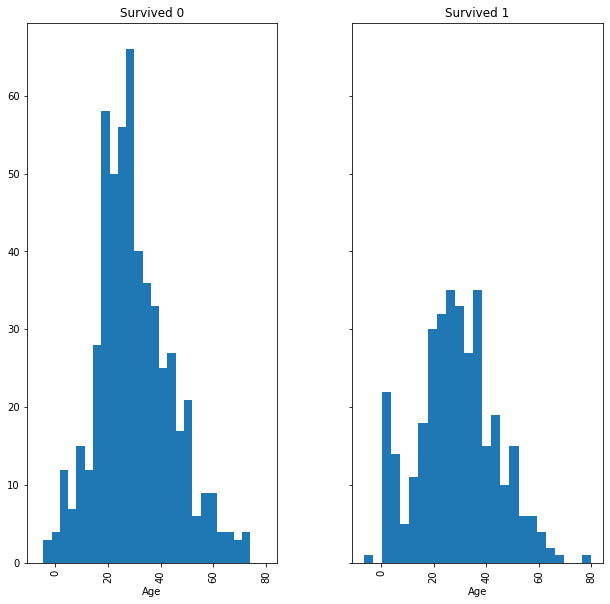

In [9]:
age_mean = train.Age.mean()
age_std = train.Age.std()
def age_rand():
    return np.random.normal(age_mean, age_std)

age_missing = train.Age.isna()
print('*** First 5 missing age values')
print(train[age_missing][['PassengerId', 'Age']].head())

print('\nAge mean is %4.2f, stddev is %4.2f' % (age_mean, age_std))

train.Age = train.Age.transform(lambda x: age_rand() if pd.isna(x) else x)

print('\n*** After filling in with Gaussian')
print(train[age_missing][['PassengerId', 'Age']].head())



fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
train.hist(column='Age', by=['Survived'], bins=25, ax=axes)

axes[0].title.set_text('Survived 0')
axes[0].set_xlabel('Age')
axes[1].title.set_text('Survived 1')
axes[1].set_xlabel('Age')

'''
Rather than just picking bands based on distribution, pick them based on
the histogram how people are treated based on their age. The very young
and very old are seen as more fragile so are more likely to have had
help surviving. Teens and young adults seem to have been left to fend
for themselves, and adults got about a 50:50 shot at survival.
'''

def age_band(age):
    if age <= 4:
        return 0
    if age <= 25:
        return 1
    if age <= 75:
        return 2
    return 3

train['AgeBand'] = train.Age.transform(age_band)


In [10]:
'''
Band fare values as they were done in the first homework
'''
def fare_ord(x):
    if x <= 7.91:
        return 0
    elif x <= 14.454:
        return 1
    elif x <= 31.0:
        return 2
    else:
        return 3
    
train['FareBand'] = train['Fare'].transform(fare_ord)
train[['Fare', 'FareBand']].head(10)

,Fare,FareBand
0,7.2500,0
1,71.2833,3
2,7.9250,1
3,53.1000,3
4,8.0500,1
5,8.4583,1
6,51.8625,3
7,21.0750,2
8,11.1333,1
9,30.0708,2


In [13]:
'''
Task 1c - learn and plot a decision tree
'''
X = train[['AgeBand', 'FareBand', 'Gender', 'Pclass']]
Y = train['Survived']
len(X)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render('5610-hw2-dectree')

'5610-hw2-dectree.pdf'

In [15]:
'''
Task 1d - 5-fold cross validation of decision tree model
'''
bins = 5
size = len(X) // bins
ranges = [x for x in range(0, bins*size, size)] + [len(X)]

accuracy = 0
for i in range(0, bins):
    low = ranges[i]
    high = ranges[i+1]
    trainX = pd.concat([X.loc[:low-1], X.loc[high:]])
    trainY = pd.concat([Y.loc[:low-1], Y.loc[high:]])
    testX = X.loc[low:high]
    testY = Y.loc[low:high]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(trainX, trainY)
    run = [x == y for (x,y) in (zip(clf.predict(testX), testY))]
    accuracy += sum(run) / len(testX)

accuracy /= bins
print('%4.2f' % (100 * accuracy))    

79.78


In [57]:
'''
Task 1e - 5-fold cross validation of random forest model
'''
accuracy = 0
for i in range(0, bins):
    low = ranges[i]
    high = ranges[i+1]
    trainX = pd.concat([X.loc[:low-1], X.loc[high:]])
    trainY = pd.concat([Y.loc[:low-1], Y.loc[high:]])
    testX = X.loc[low:high]
    testY = Y.loc[low:high]
    rf = ensemble.RandomForestClassifier()
    rf = rf.fit(trainX, trainY)
    run = [x == y for (x,y) in (zip(rf.predict(testX), testY))]
    accuracy += sum(run) / len(testX)

accuracy /= bins
print('%4.2f' % (100 * accuracy)) 

80.22


In [21]:
'''
Computation of entropy for question 3
'''
import math

def log2(x):
    '''
    Return the log base 2 of a number
    '''
    return math.log(x) / math.log(2)

def entropy(l):
    '''
    Given a list which represents the number of instances of each class in
    a set of data, return the entropy relative to that feature
    '''
    t = float(sum(l))
    e = 0
    for i in l:
        if i != 0:
            p = i/t
            e -= p*log2(p)
    return e

# data from the assignment question
data = [
    (True,  False, True),
    (True,  True,  True),
    (True,  True,  True),
    (True,  False, False),
    (True,  True,  True),
    (False, False, False),
    (False, False, False),
    (False, False, False),
    (True,  True,  False),
    (True,  False, False)
]

def dentropy(subset):
    '''
    Given a subset of data[], compute the entropy of the subset
    '''
    plus = sum(x[2] for x in subset)
    minus = len(subset) - plus
    return entropy([plus, minus])


def part(data, fn):
    '''
    Given a classifier fn, partition the data into two subsets based on
    fn(row) returning True or False
    '''
    return [[x for x in data if fn(x)], [x for x in data if not fn(x)]]

def gain(data, fn):
    '''
    Given a data set and classifier function, compute the information gain
    based on entropy of splitting the data via the classifier function
    '''
    sp = part(data, fn)
    t = float(sum([len(x) for x in sp]))
    e = dentropy(data)
    for p in sp:
        weight = len(p) / t
        ent = dentropy(p)
        e -= weight * ent
    return e
        

# feature indices
FEAT_A = 0
FEAT_B = 1
print('original entropy %5.2f' % dentropy(data))
print('gain for splitting A %5.2f' % gain(data, lambda x: x[FEAT_A]))
print('gain for splitting B %5.2f' % gain(data, lambda x: x[FEAT_B]))


original entropy  0.97
gain for splitting A  0.28
gain for splitting B  0.26
